<a href="https://colab.research.google.com/github/shadow-passwd/Data_mining_project/blob/master/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = r'/content/drive/My Drive/'

In [ ]:
## All imports here
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import gensim
import nltk
from gensim.models.word2vec import Word2Vec
import tensorflow as tf
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')
import re
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv(BASE_DIR + "clean_review.csv", engine='python', encoding='utf-8', error_bad_lines=False)

Skipping line 196678: unexpected end of data


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196676 entries, 0 to 196675
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   reviewer_id       196676 non-null  object 
 1   product_id        196676 non-null  object 
 2   rating            196676 non-null  float64
 3   unix_review_time  196676 non-null  int64  
 4   categories        196676 non-null  object 
 5   product_title     196676 non-null  object 
 6   also_buy          196676 non-null  object 
 7   brand_name        196676 non-null  object 
 8   feature           196676 non-null  object 
 9   rank              196676 non-null  object 
 10  related           196676 non-null  object 
 11  similar_item      196676 non-null  object 
 12  price             196676 non-null  object 
 13  review_text       196676 non-null  object 
 14  pos_feedback      196676 non-null  int64  
 15  neg_feedback      196676 non-null  int64  
 16  rating_class      19

In [ ]:
# assigning numeric rating class.

df['rating_class'] = df['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [ ]:
## preparing the input and output vectors for the classification model.

df.clean_text = df.clean_text.astype(str)
df.head()

,reviewer_id,product_id,rating,unix_review_time,categories,product_title,also_buy,brand_name,feature,rank,related,similar_item,price,review_text,pos_feedback,neg_feedback,rating_class,help_prop,review_time,clean_text
0,A2JXAZZI9PHK9Z,0594451647,5.0,1388707200,"['Electronics', 'Computers &amp; Accessories',...",Barnes &amp; Noble HDTV Adapter Kit for NOOK H...,[],Barnes &amp; Noble,['Connects NOOK to your high-definition televi...,"['>#1,708 in Computers &amp; Accessories &gt; ...","['B00RRFMVEE', 'B01N5F6RNV', '1400699169', 'B0...","class=""a-bordered a-horizontal-stripes a-spa...",$1.46,HDMI Nook adapter cable I am using this with a...,3,0,1,1.0,2014-01-03,hdmi nook adapter cable use nook hd work descr...
1,A2P5U7BDKKT7FW,0594451647,2.0,1398556800,"['Electronics', 'Computers &amp; Accessories',...",Barnes &amp; Noble HDTV Adapter Kit for NOOK H...,[],Barnes &amp; Noble,['Connects NOOK to your high-definition televi...,"['>#1,708 in Computers &amp; Accessories &gt; ...","['B00RRFMVEE', 'B01N5F6RNV', '1400699169', 'B0...","class=""a-bordered a-horizontal-stripes a-spa...",$1.46,Cheap proprietary scam The cable is very wobbl...,0,0,1,0.0,2014-04-27,cheap proprietary scam cable wobbly sometimes ...
2,AAZ084UMH8VZ2,0594451647,5.0,1399161600,"['Electronics', 'Computers &amp; Accessories',...",Barnes &amp; Noble HDTV Adapter Kit for NOOK H...,[],Barnes &amp; Noble,['Connects NOOK to your high-definition televi...,"['>#1,708 in Computers &amp; Accessories &gt; ...","['B00RRFMVEE', 'B01N5F6RNV', '1400699169', 'B0...","class=""a-bordered a-horizontal-stripes a-spa...",$1.46,A Perfdect Nook HD+ hook up This adaptor is re...,0,0,1,0.0,2014-05-04,perfdect nook hd hook adaptor real easy setup ...
3,AEZ3CR6BKIROJ,0594451647,4.0,1405036800,"['Electronics', 'Computers &amp; Accessories',...",Barnes &amp; Noble HDTV Adapter Kit for NOOK H...,[],Barnes &amp; Noble,['Connects NOOK to your high-definition televi...,"['>#1,708 in Computers &amp; Accessories &gt; ...","['B00RRFMVEE', 'B01N5F6RNV', '1400699169', 'B0...","class=""a-bordered a-horizontal-stripes a-spa...",$1.46,A nice easy to use accessory. This adapter eas...,0,0,1,0.0,2014-07-11,nice easy use accessory adapter easily connect...
4,A3BY5KCNQZXV5U,0594451647,5.0,1390176000,"['Electronics', 'Computers &amp; Accessories',...",Barnes &amp; Noble HDTV Adapter Kit for NOOK H...,[],Barnes &amp; Noble,['Connects NOOK to your high-definition televi...,"['>#1,708 in Computers &amp; Accessories &gt; ...","['B00RRFMVEE', 'B01N5F6RNV', '1400699169', 'B0...","class=""a-bordered a-horizontal-stripes a-spa...",$1.46,This works great but read the details... This ...,3,0,1,1.0,2014-01-20,work great read detail product really work gre...


In [ ]:
X = df['clean_text']
Y = df['rating_class']

**Tokenizing** the reviews to get the number of unique words and word indexing

In [ ]:
samples = df['clean_text']

tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(samples)

## After the tokenizer is fitted on the samples, word_index will store the mapping of each word to an integer index in the form of dictionary and 
## texts_to_sequences will convert the documents in terms of indices.

sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index

print(f"number of unique tokens = {len(word_index)}")

number of unique tokens = 191424


In [ ]:
## reverse the mapping to index each word.

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
def sequence_to_text(sequence):
    words = [reverse_word_index.get(id) for id in sequence]
    return words

review_text = list(map(sequence_to_text, sequences))

In [ ]:
print(review_text[0])
print(sequences[0])

['hdmi', 'nook', 'adapter', 'cable', 'use', 'nook', 'hd', 'work', 'describe', 'hd', 'picture', 'samsung', 'tv', 'excellent']
[410, 4036, 149, 19, 2, 4036, 368, 3, 757, 368, 62, 925, 63, 85]


In [ ]:
train_text = review_text[:25100]
print(len(train_text))

25100


**Word2Vec**

In [ ]:
word2vec = gensim.models.Word2Vec(review_text, size = 100, window = 10, min_count = 1)
word2vec.train(review_text, total_examples = len(review_text), epochs = 10)

(98481895, 107080470)

In [ ]:
similar_words = {search_term: [item[0] for item in word2vec.wv.most_similar([search_term], topn=5)]
                  for search_term in ['feel', 'good', 'product', 'cheap', 'junk', 'bad', 'great','price','love']}
similar_words

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


{'bad': ['terrible', 'ok', 'sad', 'horrible', 'defective'],
 'cheap': ['inexpensive', 'flimsy', 'cheapo', 'knockoff', 'cheep'],
 'feel': ['felt', 'seem', 'heft', 'construction', 'expensivethey'],
 'good': ['decent', 'great', 'excellent', 'nice', 'ok'],
 'great': ['fantastic', 'good', 'excellent', 'awesome', 'perfect'],
 'junk': ['garbage', 'crap', 'pos', 'junki', 'trash'],
 'love': ['awesome', 'fantastic', 'wonderful', 'enjoy', 'amaze'],
 'price': ['pricei', 'pricethe', 'cost', 'priceif', 'sale'],
 'product': ['item', 'products', 'producti', 'vendor', 'adnd']}

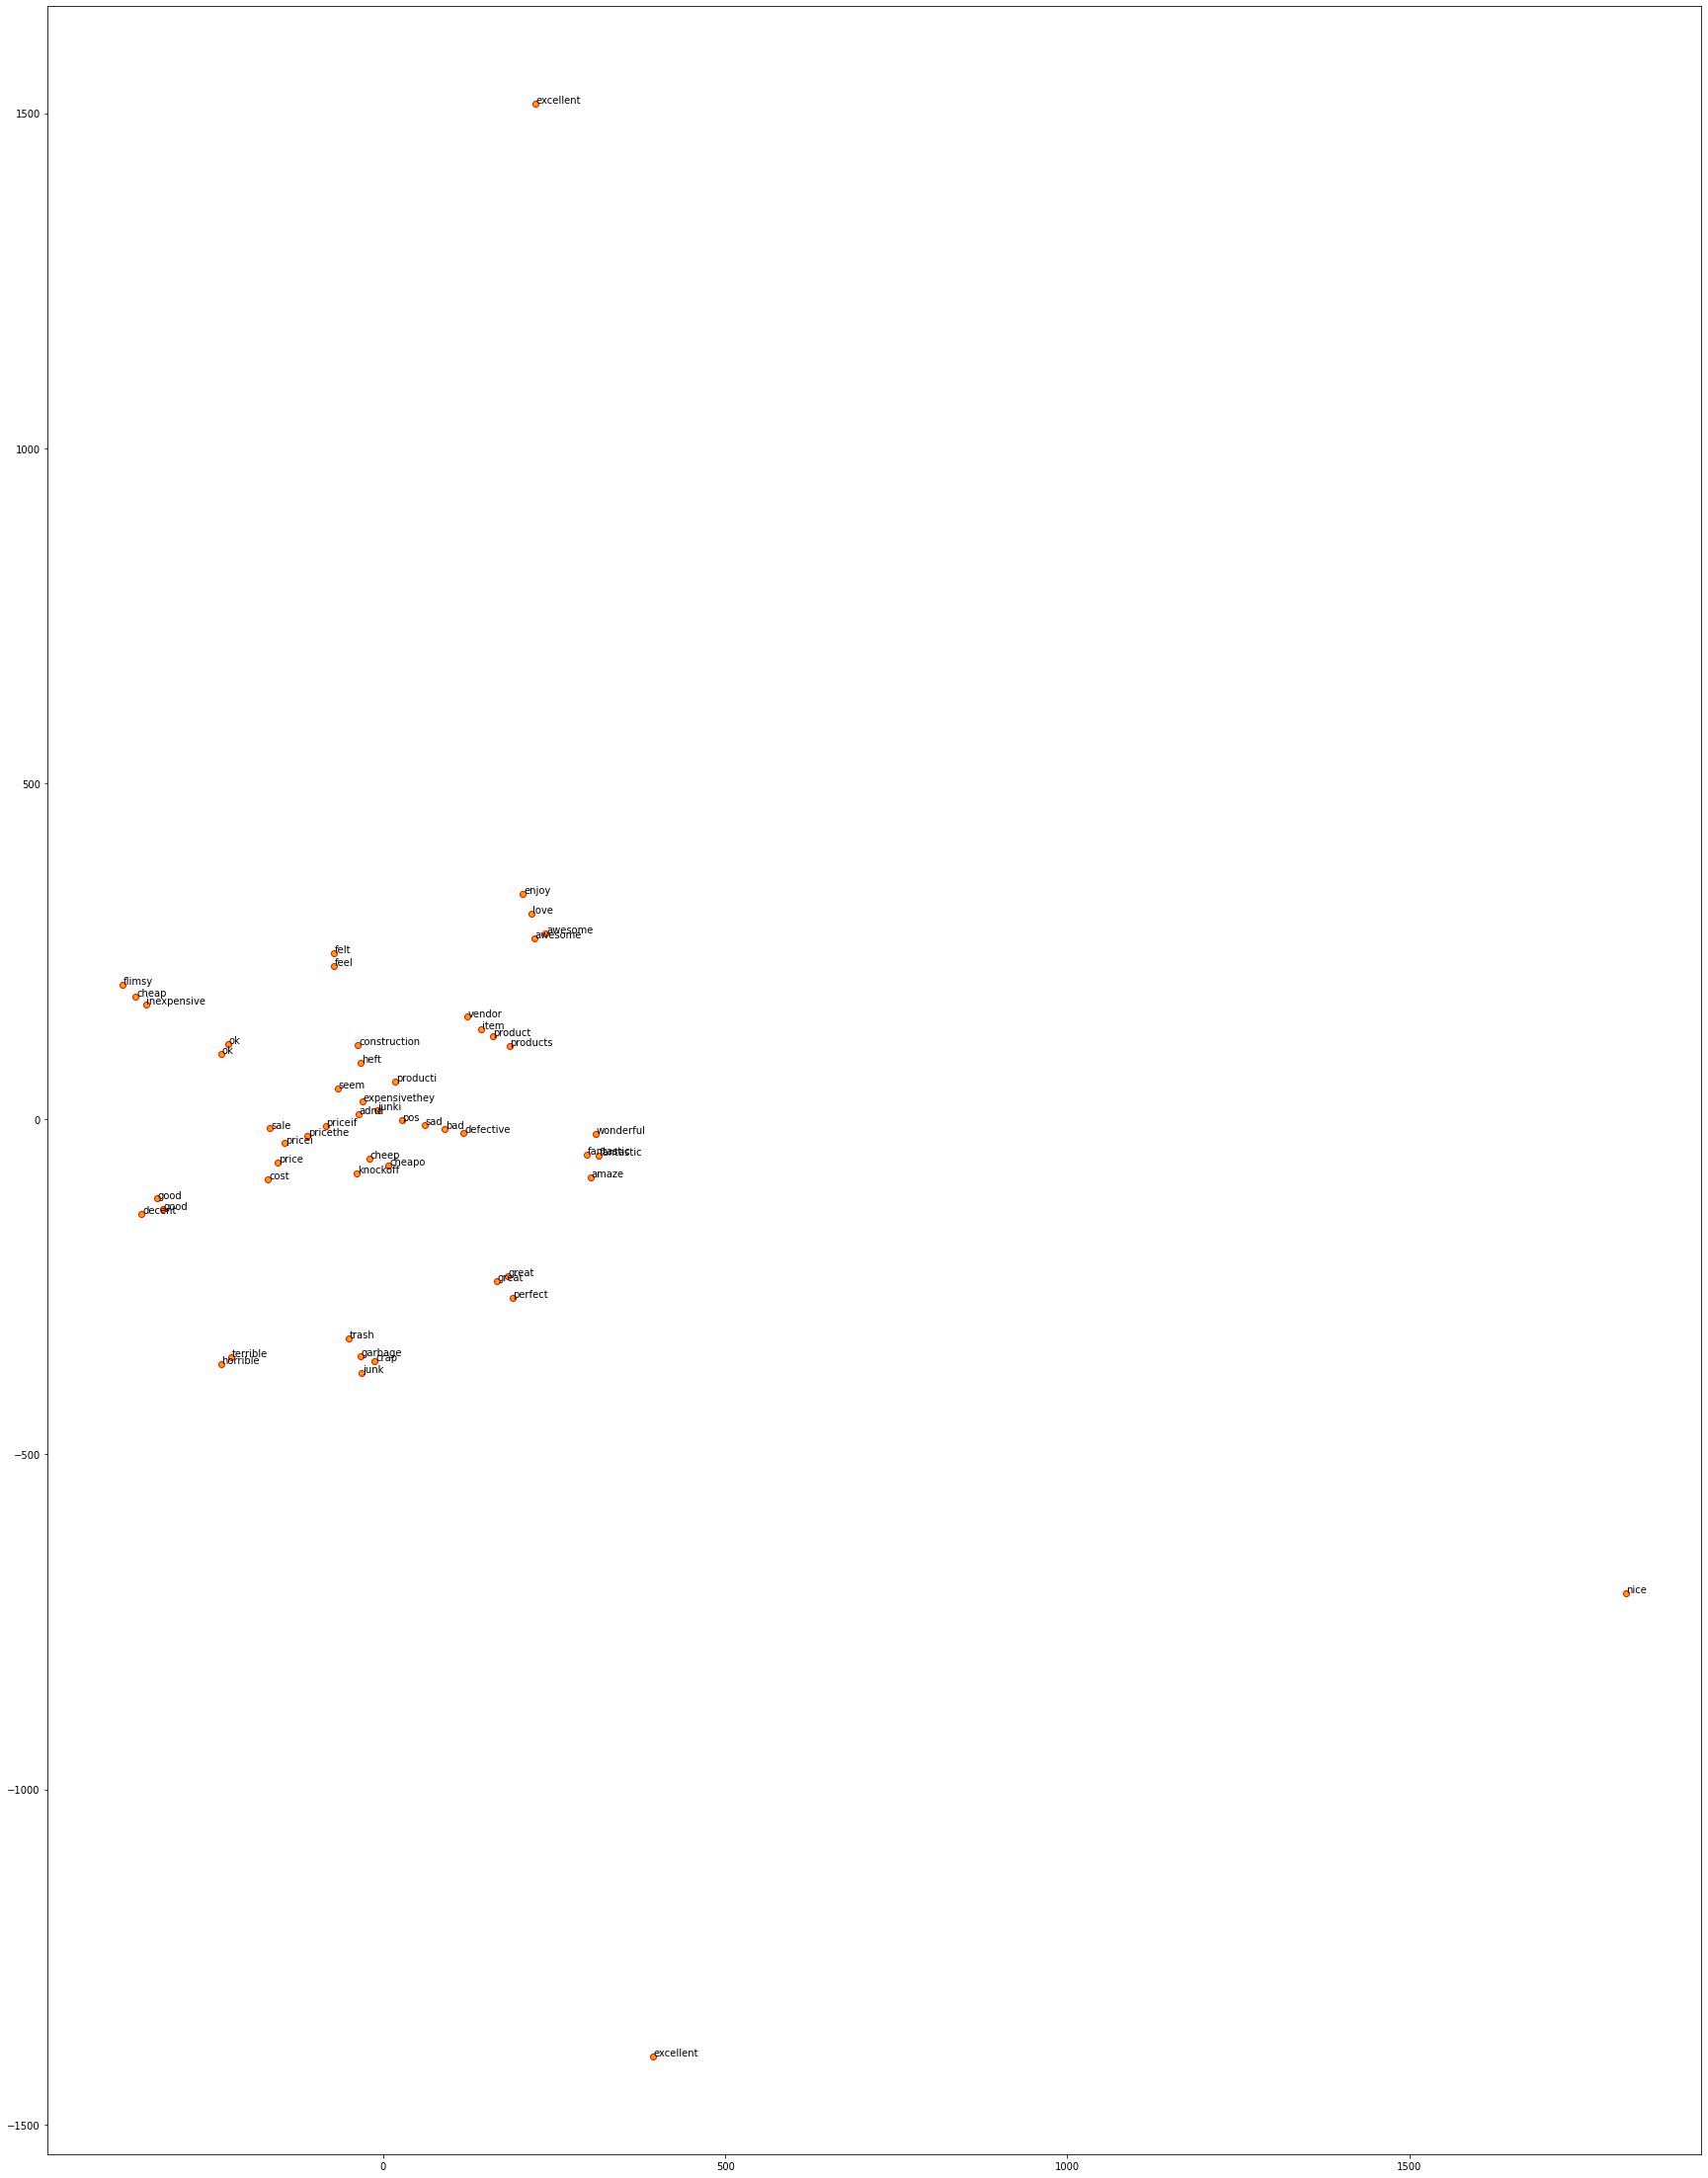

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = word2vec.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(30, 40))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, yt in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points')
